# Model 1 - Casos Normales

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from joblib import dump

In [2]:
data = pd.read_csv('data_labeled.csv').set_index('card_id').drop(['predicted', 'error', 'err_cntrbtn'], axis=1)
data = data[data['Model'] == 1].drop('Model', axis=1)

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

data.head()

,antiquity,f_1_2,f_1_3,f_1_4,f_1_5,f_2_2,f_2_3,f_3_1,target
card_id,,,,,,,,,
C_ID_92a2005557,-0.467481,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-0.820283
C_ID_3d0044924f,0.050828,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.392913
C_ID_d639edf6cd,0.569137,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.688056
C_ID_186d6a6901,-0.778466,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.142495
C_ID_cdbd2c0db2,-0.985789,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.159749


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

def rmse(y, y_pred, **kwargs):
    return np.sqrt(mean_squared_error(y, y_pred))

rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)

In [4]:
#Elastic Net
from sklearn.linear_model import ElasticNet

enet_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
             'l1_ratio':np.arange(0, 1, 0.1)}

enet = ElasticNet()

enet_cv = RandomizedSearchCV(estimator=enet, 
                             param_distributions=enet_grid, 
                             n_iter=10, 
                             scoring=rmse_scorer, 
                             n_jobs=3, 
                             cv=3,
                             random_state=42,
                             verbose=2)

enet_cv.fit(X_train, y_train)
dump(enet_cv, 'models/ensemble/model1/enet.joblib')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:   35.7s finished


['models/ensemble/model1/enet.joblib']

In [5]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_grid = {'max_depth': np.arange(5, 100, 5),
           'max_features': ['auto', 'sqrt'],
           'min_samples_leaf': [1, 10, 50, 100],
           'min_samples_split': [2, 10, 100, 200],
           'n_estimators': np.arange(250, 2000, 250)}

rf = RandomForestRegressor()

rf_cv = RandomizedSearchCV(estimator=rf, 
                           param_distributions=rf_grid, 
                           n_iter=10, 
                           scoring=rmse_scorer, 
                           n_jobs=3, 
                           cv=3,
                           random_state=42,
                           verbose=2)

rf_cv.fit(X_train, y_train)
dump(rf_cv, 'models/ensemble/model1/rf.joblib')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 27.2min finished


['models/ensemble/model2/rf.joblib']

In [6]:
#Light GBM
from lightgbm import LGBMRegressor

lgbm_grid = {'learning_rate': np.arange(0.1, 1, 0.1),
             'n_estimators': np.arange(100, 2000, 100),
             'reg_alpha': [0.001, 0.01, 0.1, 1, 10, 100],
             'reg_lambda': [0.001, 0.01, 0.1, 1, 10, 100]}

lgbm = LGBMRegressor()

lgbm_cv = RandomizedSearchCV(estimator=lgbm,
                             param_distributions=lgbm_grid,
                             n_iter=10,
                             scoring=rmse_scorer,
                             n_jobs=3,
                             cv=3,
                             random_state=42,
                             verbose=2)

lgbm_cv.fit(X_train, y_train)
dump(lgbm_cv, 'models/ensemble/model1/lgbm.joblib')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  7.6min finished


['models/ensemble/model1/lgbm.joblib']

|Elastic Net | RMSE on validation set = 1.683|
|Cross validation distribution: mean = 1.719 | min = 1.718 | max = 1.722|

|Random Forest | RMSE on validation set = 1.682|
|Cross validation distribution: mean = 1.719 | min = 1.718 | max = 1.722|

|LightGBM | RMSE on validation set = 1.682|
|Cross validation distribution: mean = 1.719 | min = 1.718 | max = 1.722|



Text(0.5,0,'')

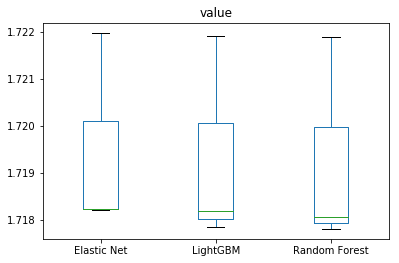

In [9]:
models = [('Elastic Net', enet_cv),
          ('Random Forest', rf_cv),
          ('LightGBM', lgbm_cv)]

reverse_sign = True
scores_dict = {}
for model in models:
    label, estimator = model
    scores = np.array([estimator.cv_results_['split{}_test_score'.format(i)][estimator.best_index_] for i in range(estimator.cv)])
    if reverse_sign: scores = -scores
    scores_dict[label] = scores
    y_pred = estimator.best_estimator_.predict(X_test)
    print('|{label} | RMSE on validation set = {rmse}|'.format(label=label, rmse=round(rmse(y_test, y_pred), 3)))
    print('|Cross validation distribution: mean = {mean} | min = {min} | max = {max}|\n'.format(min=round(scores.min(), 3), max=round(scores.max(), 3), mean=round(scores.mean(), 3)))
    
#Plot results
ax = pd.melt(pd.DataFrame.from_dict(scores_dict)).boxplot(by='variable', grid=False)
fig = ax.get_figure()
fig.suptitle('')
plt.xlabel('')